In [39]:
%load_ext autoreload
%autoreload 1
%aimport utils
from utils import *
import matplotlib.gridspec as gridspec
import os
from IPython import display
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
execfile('../../matplotlibrc.py')

# Question 1

In [22]:
print read_params()

&dat
 params%flx_scheme=1,
 params%timestep_scheme=1,
 params%nx=50,
 params%p_exit_ratio=0.8,
 params%eps=0.3,
 params%tol=1e-14,
 params%max_iter=100000,
 params%cfl=0.2/



In [14]:
def savefig(fig, name):
    filepath = 'tex/figs/%s.pdf' % name
    fig.tight_layout()
    fig.savefig(filepath)

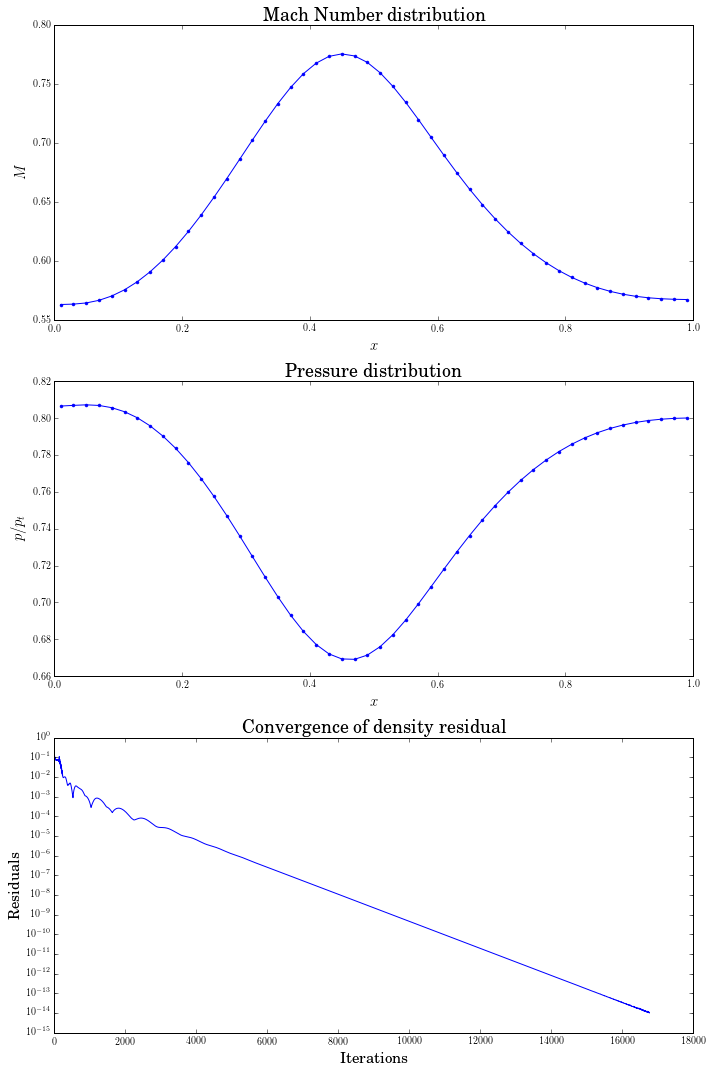

In [111]:
def q1():
    modify_param('flx_scheme', 1)
    modify_param('timestep_scheme', 1)
    modify_param('max_iter', 100000)
    modify_param('p_exit_ratio', 0.8)
    modify_param('nx', 50)
    modify_param('eps', 0.30)
    modify_param('cfl', 0.4)
    run()
    state, resi, time = read_data()
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 15))
    plot_mach(state, ax1)
    plot_pressure(state, ax2)
    plot_residual(resi, ax3)
    savefig(fig, 'q1')
    
q1()

# Question 2 - Exit Pressure Study

In [78]:
q2_params = {
    'flx_scheme': 1,
    'timestep_scheme': 1,
    'max_iter': 1000000,
    'nx': 50,
    'cfl':0.1,
}

In [79]:
def q2_test():
    """Used to look for correct epsilon value"""
    for k, v in q2_params.items():
        modify_param(k, v)
    
    modify_param('p_exit_ratio', 0.76)
    eps = float(raw_input('Enter EPS: '))
    modify_param('eps', eps)
    run()
    state, resi, time = read_data()
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 14))
    plot_pressure(state, ax1)
    plot_mach(state, ax2)
    
# q2_test()

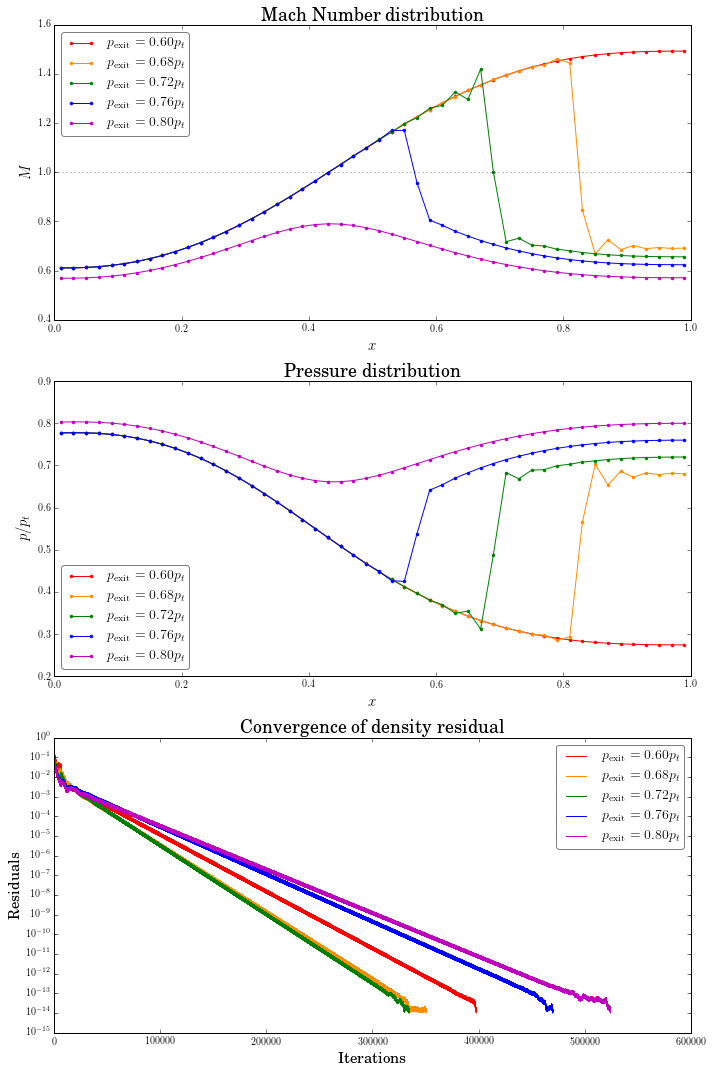

In [80]:
def q2():
    for k, v in q2_params.items():
        modify_param(k, v)
    eps = 0.05
    pratios = [0.6, 0.68, 0.72, 0.76, 0.8]
    colors = mk_colors(pratios)
    colors = reversed(colors)
    modify_param('eps', eps)
    fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
    ax1, ax2, ax3 = axes
    for color, pratio in zip(colors, pratios):
        modify_param('p_exit_ratio', pratio)
        out = run()
        state, resi, time = read_data()
        label = r'$p_{\mathrm{exit}} = %.2f p_t$' % pratio
        opt = dict(color=color, label=label)
        plot_mach(state, ax1, **opt)
        plot_pressure(state, ax2, **opt)
        plot_residual(resi, ax3, **opt)
    
    for ax in axes:
        ax.legend()
    fig.tight_layout()
    savefig(fig, 'q2')
    
q2()

Lack of dissipation leads to wiggles. Solution still stable, i.e. does not blow up, but the dispersion errors become dominant in these cases. 

Moreover, the shock is completely dissipated and leads to fully supersonic flow at pexit = 0.6. 

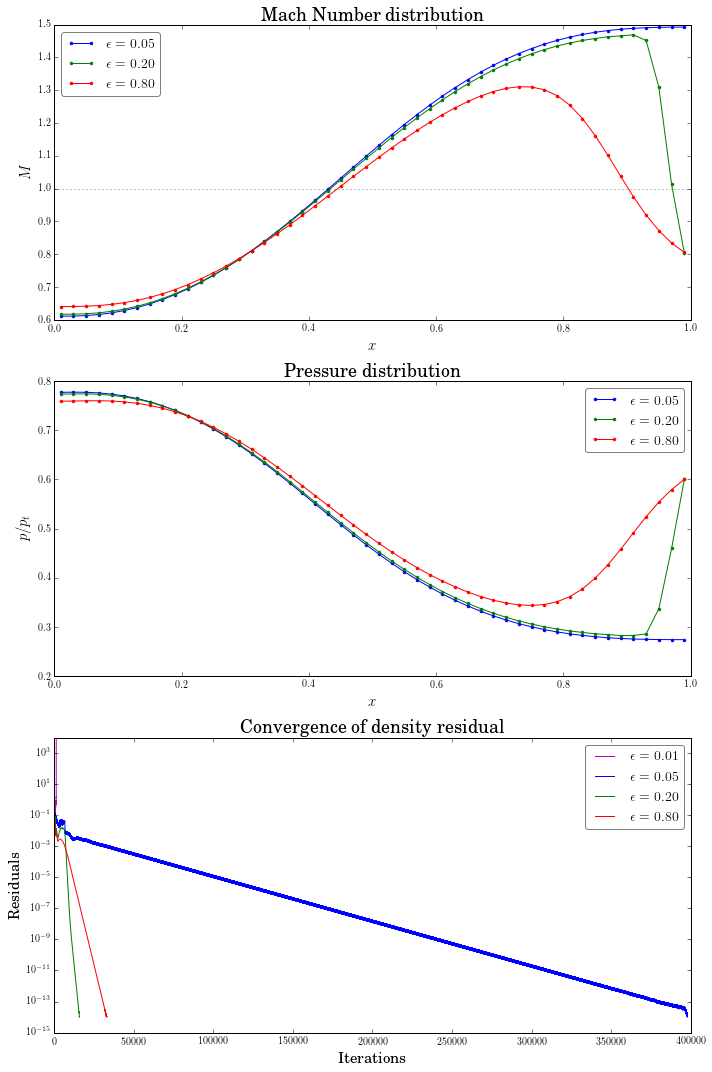

In [82]:
def q2_eps():
    for k, v in q2_params.items():
        modify_param(k, v)
    
    pratio = 0.6
    modify_param('p_exit_ratio', pratio)
    all_eps = [0.01, 0.05, 0.2, 0.8]
    colors = mk_colors(all_eps)
    fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
    ax1, ax2, ax3 = axes
    for color, eps in zip(colors, all_eps):
        modify_param('eps', eps)
        out = run()
        state, resi, time = read_data()
        label = r'$\epsilon = %.2f$' % eps
        opt = dict(color=color, label=label)
        plot_residual(resi, ax3, **opt)
        if eps == all_eps[0]:
            continue
        plot_mach(state, ax1, **opt)
        plot_pressure(state, ax2, **opt)
        
    for ax in axes:
        ax.legend()
    ylim1, ylim2 = ax3.get_ylim()
    ax3.set_ylim(ylim1, 10000)
    fig.tight_layout()
    savefig(fig, 'q2_eps')
    
q2_eps()

---
# Question 3 - Grid Study

In [12]:
def find_shock_mach(mach):
    idx = [i for i in range(len(mach) - 1)
           if (mach[i+1] < mach[i]) and i > len(mach)/2]
    return idx[0]

[0.96855444024563053, 0.96576424657534243, 0.96338214926783183, 0.96215401039206427]
[1.0714485645286649, 1.213121340093982, 1.2999128177363024, 1.3431756081279491]
\begin{tabular}{@{} r c @{}}
        \toprule
        $N$ & $p_{t,\mathrm{exit}}/p_{t,\mathrm{inlet}}$ \\
        \midrule
        
25 & 0.9686 \\
50 & 0.9658 \\
100 & 0.9634 \\
200 & 0.9622 \\

        \bottomrule
        \end{tabular}


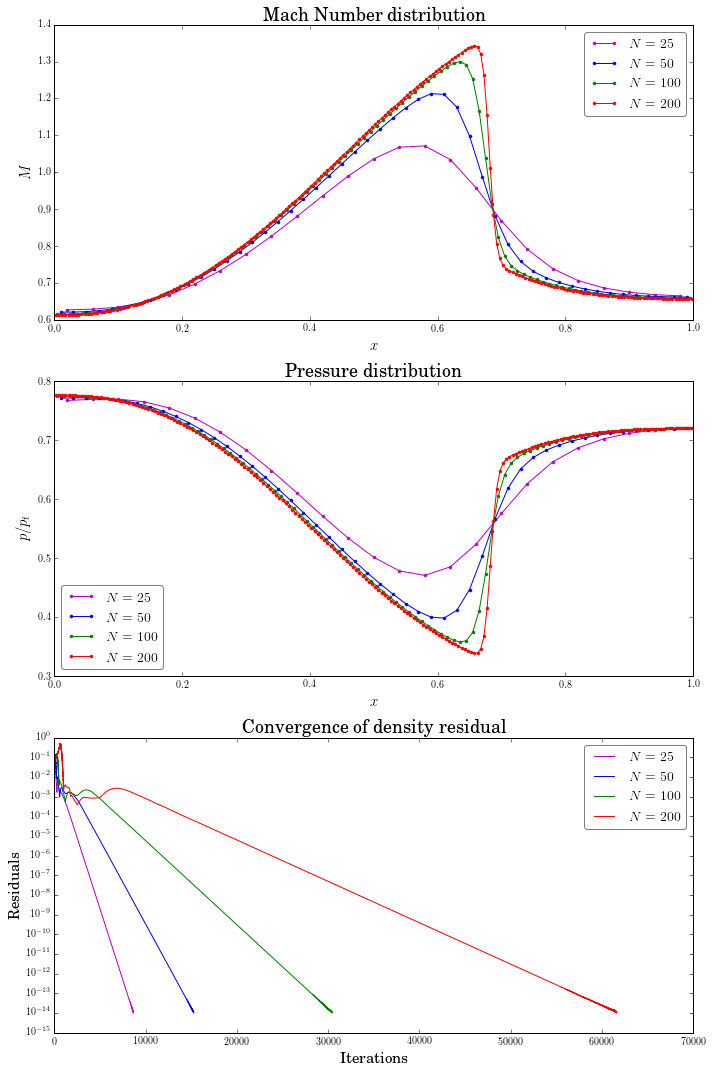

In [92]:
def q3():
    modify_param('flx_scheme', 1)
    modify_param('timestep_scheme', 1)
    modify_param('cfl', 0.4)
    modify_param('max_iter', 1000000000)
    modify_param('p_exit_ratio', 0.72)
    modify_param('eps', 0.3)
    
    all_nx = [25, 50, 100, 200]
    colors = mk_colors(all_nx)
    fig, axes = plt.subplots(nrows=3, figsize=(10, 15))
    ax1, ax2, ax3 = axes
    ploss = []
    mx = []
    for color, nx in zip(colors, all_nx):
        modify_param('nx', nx)
        out = run()
        state, resi, time = read_data()
        label = r'$N = %d$' % nx
        opt = dict(color=color, label=label)
        plot_residual(resi, ax3, **opt)
        plot_mach(state, ax1, **opt)
        plot_pressure(state, ax2, **opt)
        
        mach = calc_mach(state)
        idx = find_shock_mach(mach)
        mx.append(mach[idx])
        ploss.append(state['ptot'][-1]/state['ptot'][0])
        
    print ploss
    print mx
    for ax in axes:
        ax.legend()

    fig.tight_layout()
    savefig(fig, 'q3')
    
    table_fmt = r'''\begin{tabular}{@{} r c @{}}
        \toprule
        $N$ & $p_{t,\mathrm{exit}}/p_{t,\mathrm{inlet}}$ \\
        \midrule
        
%s

        \bottomrule
        \end{tabular}'''
    lines = []
    for i in range(len(all_nx)):
        lines.append(r'%d & %.4f \\' % (all_nx[i], ploss[i]))
    body = '\n'.join(lines)
    table = table_fmt % body
    print table
    open('tex/table_q3_ploss.tex', 'w').write(table)
    
q3()

In [93]:
def q3_eps():
    modify_param('flx_scheme', 1)
    modify_param('timestep_scheme', 1)
    modify_param('cfl', 0.4)
    modify_param('max_iter', 10000)
    modify_param('p_exit_ratio', 0.72)
    
    all_nx = [25, 50, 100, 200]
    step = -0.01
    all_eps = np.arange(0.3, 0.05 + step, step)
    min_eps = []
    for nx in all_nx:
        modify_param('nx', nx)
        for eps in all_eps:
            modify_param('eps', eps)
            out = run()
            if 'unconverged' in out.lower():
                min_eps.append(eps)
                break
                
    table_fmt = r'''\begin{tabular}{@{} r c @{}}
        \toprule
        $N$ & $\epsilon_{\mathrm{min}}$ \\
        \midrule

%s

        \bottomrule
        \end{tabular}
    '''
    lines = []
    for i in range(len(all_nx)):
        lines.append(r'%d & %.2f \\' % (all_nx[i], min_eps[i]))
    body = '\n'.join(lines)
    table = table_fmt % body
    print(table)
    open('tex/table_q3_eps.tex', 'w').write(table)
            
q3_eps()

\begin{tabular}{@{} r c @{}}
        \toprule
        $N$ & $\epsilon_{\mathrm{min}}$ \\
        \midrule

25 & 0.18 \\
50 & 0.19 \\
100 & 0.23 \\
200 & 0.27 \\

        \bottomrule
        \end{tabular}
    


### Discussion
Refining the mesh takes more iterations, but a mesh too coarse cannot capture the shock adequately.

However, the solutions seem to be converging towards a mesh-independent solution.

---
# Question 4 - Spatial Discretization Scheme Study

matplotlib.cbook.silent_list

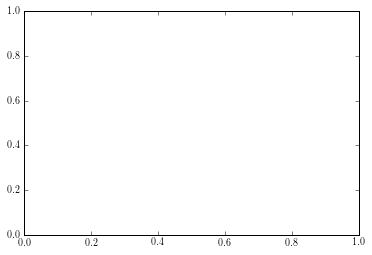

In [75]:
fig, ax = plt.subplots()
t = ax.yaxis.get_ticklabels()
type(t)

\begin{tabular}{@{} r c @{}}
        \toprule
        Scheme & $p_{t,\mathrm{exit}}/p_{t,\mathrm{inlet}}$ \\
        \midrule
        
SD & 0.9643 \\
SW & 0.9622 \\
MSW & 0.9602 \\
CMSW & 0.9602 \\
Roe & 0.9602 \\

        \bottomrule
        \end{tabular}


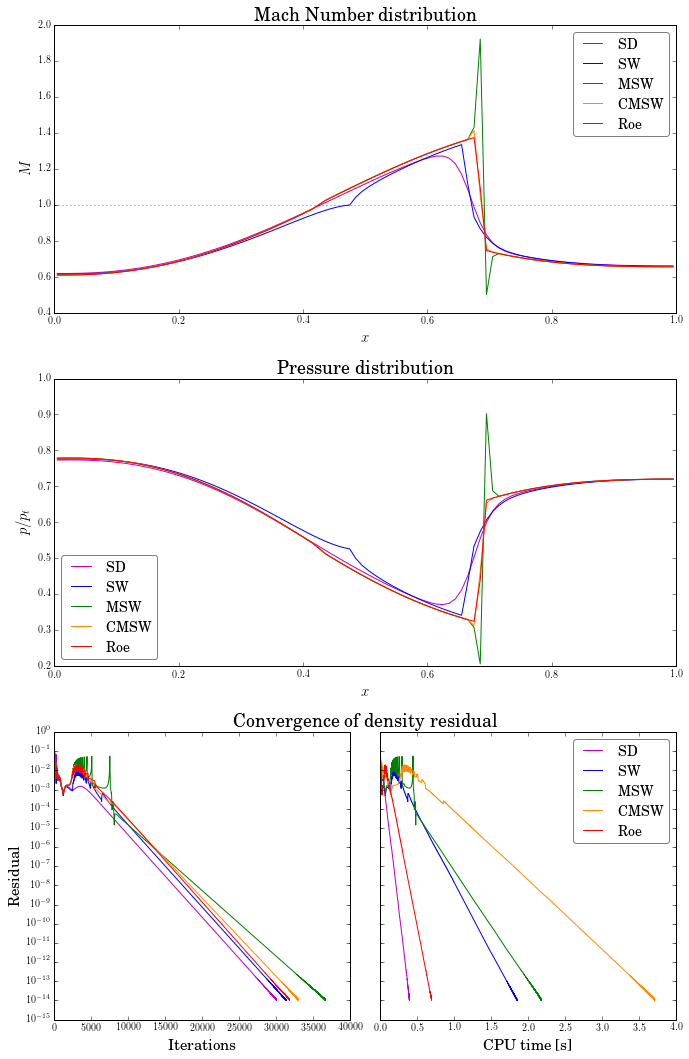

In [91]:
def q4():
    modify_param('timestep_scheme', 1)
    modify_param('max_iter', 100000)
    modify_param('nx', 100)
    modify_param('cfl', 0.4)
    modify_param('eps', 0.4)
    modify_param('p_exit_ratio', 0.72)
    flx_schemes = [
        (1, 'SD'),
        (2, 'SW'),
        (3, 'MSW'),
        (4, 'CMSW'),
        (5, 'Roe'),
    ]
    fig = plt.figure(figsize=(10, 15))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    axtitle = fig.add_subplot(313)
    hide_ax(axtitle)
    ax3 = fig.add_subplot(325)
    ax4 = fig.add_subplot(326, sharey=ax3)
    plt.setp(ax4.get_yticklabels(), visible=False)
    
    colors = mk_colors(flx_schemes)
    ploss = []
    for flx_scheme, name in flx_schemes:
        i = flx_scheme - 1
        color = colors[i]
        modify_param('flx_scheme', flx_scheme)
        run()
        state, resi, time = read_data()
        label = name
        opt = dict(color=color, label=label, marker='')
        plot_mach(state, ax1, **opt)
        plot_pressure(state, ax2, **opt)
        plot_residual(resi, ax3, do_labels=False, **opt)
        plot_residual_time(resi, time, ax4, do_labels=False, **opt)
        ploss.append(state['ptot'][-1]/state['ptot'][0])
        
    axtitle.set_title('Convergence of density residual')
    ax3.set_ylabel('Residual')
    ax3.set_xlabel('Iterations')
    ax4.set_xlabel('CPU time [s]')
        
    for ax in [ax1, ax2, ax4]:
        ax.legend()
        
    fig.tight_layout()
    savefig(fig, 'q4')
    
    table_fmt = r'''\begin{tabular}{@{} r c @{}}
        \toprule
        Scheme & $p_{t,\mathrm{exit}}/p_{t,\mathrm{inlet}}$ \\
        \midrule
        
%s

        \bottomrule
        \end{tabular}'''
    lines = []
    for i in range(len(flx_schemes)):
        lines.append(r'%s & %.4f \\' % (flx_schemes[i][1], ploss[i]))
    body = '\n'.join(lines)
    table = table_fmt % body
    print table
    open('tex/table_q4_ploss.tex', 'w').write(table)
    
q4()

### Discussion

Indeed, MSW does not contain enough dissipation in the region of discontinuity -- it is greatly amplified. CMSW corrects for that and provides a more realistic behavior. However, it requires the most time. 

The Scalar Dissipation is the most dissipative of all.

----
# Question 5 - Temporal Discretization Scheme Study

## With Roe

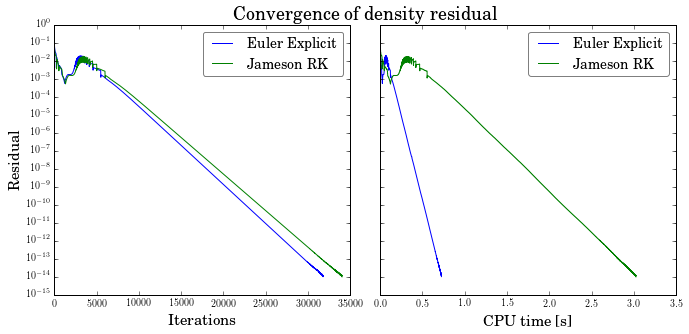

In [99]:
def q5():
    modify_param('nx', 100)
    modify_param('p_exit_ratio', 0.72)
    modify_param('cfl', 0.4)
    modify_param('flx_scheme', 5)
    modify_param('max_iter', 100000)
    
    time_schemes = [
        (1, 'Euler Explicit'),
        (2, 'Jameson RK'),
    ]
    fig = plt.figure(figsize=(10, 5))
    axtitle = fig.add_subplot(111)
    hide_ax(axtitle)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    colors = mk_colors(time_schemes)
    for num, time_scheme in time_schemes:
        i = num - 1
        modify_param('timestep_scheme', num)
        run()
        state, resi, time = read_data()
        color = colors[i]
        label = time_scheme
        opt = dict(color=color, label=label)
        plot_residual(resi, ax1, do_labels=False, **opt)
        plot_residual_time(resi, time, ax2, do_labels=False, **opt)
        
    axtitle.set_title('Convergence of density residual')
    ax1.set_ylabel('Residual')
    ax1.set_xlabel('Iterations')
    ax2.set_xlabel('CPU time [s]')
        
    for ax in [ax1, ax2]:
        ax.legend()
        
    savefig(fig, 'q5')
    
q5()

0.8
0.85
0.9
0.95
0.8
0.85
0.9
0.95
1.0
1.05
1.1
1.15
1.2
1.25
1.3
1.35
1.4
1.45
1.5
1.55
\begin{tabular}{@{} r c c}
        \toprule
        Scheme & CFL$_{\mathrm{max}}$ & Time [s] \\
        \midrule
        
Euler & 0.90 & 0.32 \\
Jameson & 1.50 & 0.79 \\        
  
        \bottomrule
        \end{tabular}
        


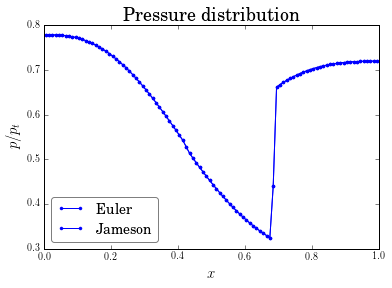

In [106]:
def q5():
    modify_param('nx', 100)
    modify_param('p_exit_ratio', 0.72)
    modify_param('flx_scheme', 5)
    modify_param('max_iter', 100000)
    
    time_schemes = [
        (1, 'Euler'),
        (2, 'Jameson'),
    ]
    step = 0.05
    all_cfl = np.arange(0.8, 2.0 + step, step)
    lines = []
    fig, ax = plt.subplots()
    for num, time_scheme in time_schemes:
        i = num - 1
        modify_param('timestep_scheme', num)
        for cfl in all_cfl:
            modify_param('cfl', cfl)
            out = run()
            print cfl
            if 'unconverged' in out.lower():
                line = r'%s & %.2f & %.2f \\' % (time_scheme, cfl - step, time[-1])
                lines.append(line)
                plot_pressure(state, ax, label=time_scheme)
                break
            state, resi, time = read_data()  
            
    ax.legend()
    
    table_fmt = r'''\begin{tabular}{@{} r c c}
        \toprule
        Scheme & CFL$_{\mathrm{max}}$ & Time [s] \\
        \midrule
        
%s        
  
        \bottomrule
        \end{tabular}
        '''
    body = '\n'.join(lines)
    table = table_fmt % body
    print table
    open('tex/table_q5.tex', 'w').write(table)
    
        
q5()